<b> <font size="+2.5"> H-MAGMA analysis
 </b> </font> <br>

Compare celltype-specific Age DEGs with previously identified GWAS risk genes <br>
of psychiatric disorders (https://pubmed.ncbi.nlm.nih.gov/32152537/) <br>
with the MAGMA enrichment method

Date: 2024-01-19 <br>
Author: ASF & NG

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(data.table)
library(tidyr)
library(dplyr)
library(stringr)
library(readxl)
library(fgsea)
library(ggplot2)
library(viridis)
})

# read in Age DE results

In [2]:
# read in the gene information to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')
head(gene_names_ensembl)

,ID,ensembl
,<chr>,<chr>
1,AL627309.1,ENSG00000238009
2,AL627309.5,ENSG00000241860
3,LINC01409,ENSG00000237491
4,LINC01128,ENSG00000228794
5,LINC00115,ENSG00000225880
6,FAM41C,ENSG00000230368


In [3]:
# read in Age DE results
# merge gene with ensembl ID

celltypes <- c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", "Exc_L5-6_1", "Exc_L5-6_2", "Exc_L5-6_HTR2C", "In_LAMP5_1", "In_LAMP5_2", "In_PVALB_Ba", "In_PVALB_Ch", "In_RELN", "In_SST", "In_VIP", "Microglia", "Oligodendrocyte", "OPC")

# full DE results
# not filtered for sig genes
DE_genes_Age <- list()
for (celltype in celltypes){
    tmp <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx', sheet = celltype))
    #merge gene ID and ensembl ID
    DE_genes_Age[[celltype]] <- merge(tmp, gene_names_ensembl, by='ID')
}

In [4]:
head(DE_genes_Age[['Astro_FB']])

,ID,assay,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std,ensembl
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AACS,Astro_FB,-0.0033641126,5.307076,-0.7058437,0.482304421,0.78653694,-7.509535,-0.7026010,ENSG00000081760
2,AAGAB,Astro_FB,-0.0009386816,5.503497,-0.2187334,0.827349407,0.94511370,-7.785788,-0.2181023,ENSG00000103591
3,AAK1,Astro_FB,-0.0003949590,7.409168,-0.1426621,0.886916330,0.96583046,-7.984447,-0.1422072,ENSG00000115977
4,AARS,Astro_FB,0.0021342127,5.440289,0.4856405,0.628516808,0.86362817,-7.685330,0.4838155,ENSG00000090861
5,AASDH,Astro_FB,0.0030634427,6.397805,0.8096060,0.420558808,0.74728779,-7.566368,0.8054522,ENSG00000157426
6,AASDHPPT,Astro_FB,-0.0130360167,5.178886,-3.3243941,0.001318383,0.04572419,-2.527363,-3.2119478,ENSG00000149313


# Create gene_covar file

In [5]:
# Create gene_covar file for each cell type
# using ensembl ID ('ensembl')

for (celltype in celltypes){
  # prepare file with continuous variable and all genes (NEEDED as input)
    # -log10(p-value)*log2(fold change)
  gene_df <- DE_genes_Age[[celltype]] %>%
    dplyr::select(ensembl, adj.P.Val, logFC) 
  gene_df$adj.P.Val[is.na(gene_df$adj.P.Val)] <- 1
  gene_df <- gene_df %>% 
    mutate(log_padj = -log10(adj.P.Val)) %>%
    mutate(score = log_padj*logFC)
  #write.table(gene_df, file = paste0("../H_MAGMA/MAGMAinput/Age/", celltype, "_gene_covar.txt"),
              #quote = FALSE, row.names = FALSE, col.names = TRUE, sep = "\t")
  
}

# Map GWAS results to genes

see folder 09_Overlap_Age_psychopathology; run the script 2b_H-MAGMA_map_GWAS_to_genes.sh

# Perform enrichment

see folder 09_Overlap_Age_psychopathology; run the script 2c_MAGMA_GWASenrichment.sh

# Fig.7f - Plot results

In [6]:
# GWAS of interest from H-MAGMA results
traits <- c("BIP2021", "MDD", "SCZ" , "AD", 'hypertension')

# 1. Read in calculated H-MAGMA results
magma_list <- list()
for (trait in traits){
  
  # find all files for one trait with file pattern
  p <- paste0(trait, "_.*_magmaEnrichment.gsa.out")
  files <- list.files(path = paste0("../H_MAGMA/MAGMAoutput/Age/"),
                      pattern = p,
                      full.names = FALSE)
  # read in the files
  magma_score_list <- list()
  for (f in files){
    m <- read.table(paste0("../H_MAGMA/MAGMAoutput/Age/", f),
                    skip = 3, header = TRUE)
    ct <- sub(paste0(trait,"_(.*)_magmaEnrichment.gsa.out"),"\\1",f)
    magma_score_list[[ct]] <- m[m$VARIABLE == "score",]
  }
  celltypes <- names(magma_score_list)
  
  magma_score_df <- bind_rows(magma_score_list, .id="celltype")
  # magma_score_df$FDR <- p.adjust(magma_score_df$P, method = "fdr")
  
  magma_list[[trait]] <- magma_score_df
}

magma_df <- dplyr::bind_rows(magma_list, .id="trait")
magma_df$FDR <- p.adjust(magma_df$P, method="fdr")
head(magma_df)

,trait,celltype,VARIABLE,TYPE,NGENES,BETA,BETA_STD,SE,P,FDR
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BIP2021,Astro_FB,score,COVAR,4824,2.93080,0.01416200,3.34130,0.38045,0.8428286
2,BIP2021,Astro_PP,score,COVAR,9931,0.13570,0.00065133,2.09660,0.94840,0.9644250
3,BIP2021,Endothelial,score,COVAR,2633,-4.37190,-0.01660700,6.22220,0.48236,0.8732379
4,BIP2021,Exc_L2-3,score,COVAR,16518,-1.43670,-0.01180800,0.94213,0.12730,0.8428286
5,BIP2021,Exc_L3-5,score,COVAR,8363,-2.67590,-0.00957240,3.12360,0.39164,0.8428286
6,BIP2021,Exc_L4-6_1,score,COVAR,12173,-0.47038,-0.00259490,1.63220,0.77320,0.9440233


In [7]:
#format
magma_df$trait[magma_df$trait == 'BIP2021'] <- 'BPD'
magma_df$trait[magma_df$trait == 'hypertension'] <- 'HTN' 

magma_df$trait <- factor(magma_df$trait, levels=c("BPD", "MDD", "SCZ" , "AD", 'HTN'))
magma_df$celltype <- factor(magma_df$celltype, levels=rev(c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3",
                                                        "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3",
                                                        "Exc_L5-6_1", "Exc_L5-6_2", "Exc_L5-6_HTR2C", "In_LAMP5_1",
                                                        "In_LAMP5_2", "In_PVALB_Ba", "In_PVALB_Ch", "In_RELN",
                                                        "In_SST", "In_VIP", "Microglia", "Oligodendrocyte", "OPC")))

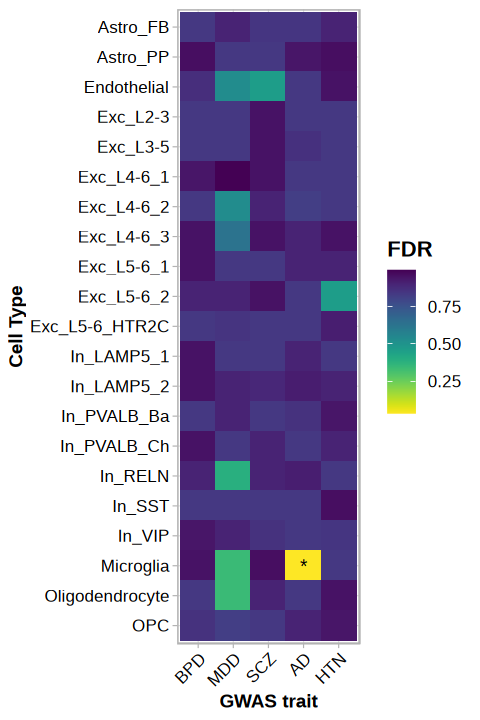

In [8]:
###
## Plot MAGMA p-values as heatmap from all traits and cell types
# color FDR
magma_df$sig <- ifelse(magma_df$FDR <= 0.05, "*", "")

options(repr.plot.width=4, repr.plot.height=6)
ggplot(magma_df, aes(x = trait, y = celltype, fill = FDR, label = sig)) +
  geom_tile() +
  geom_text() +
  xlab("GWAS trait") +
  ylab("Cell Type") +
  scale_fill_viridis(direction=-1) +
  theme_light() +
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 45, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))

#ggsave(filename = '../H_MAGMA/heatmap_HMAGMA_FDR.pdf',
      # width = 3.8, height = 5.3)

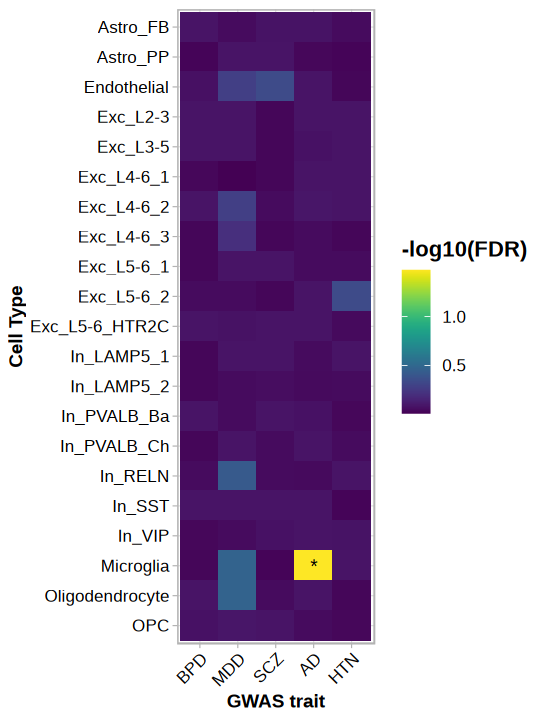

In [9]:
# color -log10(FDR)

options(repr.plot.width=4.5, repr.plot.height=6)
ggplot(magma_df, aes(x = trait, y = celltype, fill = -log10(FDR), label = sig)) +
  geom_tile() +
  geom_text() +
  xlab("GWAS trait") +
  ylab("Cell Type") +
  scale_fill_viridis(direction=1) +
  theme_light() +
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 45, hjust=1)) + 
  theme(legend.text = element_text(size=10), legend.position = 'right') + theme(legend.title=element_text(size=13, face='bold'))

#ggsave(filename = '../H_MAGMA/heatmap_HMAGMA_-log10(FDR).pdf',
      # width = 3.8, height = 5.3)

# SessionInfo

In [10]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] viridis_0.6.4     viridisLite_0.4.2 ggplot2_3.4.4     fgsea_1.28.0     
[5] readxl_1.4.3      stringr_1.5.1     dplyr_1.1.4       tidyr_1.3.0      
[9] data.table_1.14.8

loaded via a namespace (and not atta